In [235]:
from datetime import datetime
import pandas as pd
import numpy as np
from dateutil.parser import parse
pd.set_option('max_rows', 15)
pd.set_option('max_columns', 15)
import datetime
from dateutil.parser import parse
import math

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

### Cilj raziskave
Namen modeliranja je napovedati preseženo vrednost toksinov v školjkah na podlagi abundance mikroalg v kombinaciji z okoljskimi parametri. (Pristojni se odločajo o zapori prodaje školjk na podlagi testov toksičnostu). Biologe zanima katere vrste so tiste ki vplivajo na pojavnost toksinov.

# Data preprocessing

## Micro-algae dataset

In [236]:
# Create micro-algae dataframe (empty cells -> NaN)
df_alg = pd.read_csv("data/Algae_Podatki_1994_onwards_24062021_Martin_1_0.csv", na_values = ["NA", "?"], sep=";")

# Keep only columns: PSP,  DSP,  Dinophysis species of special interest,  DSP_like,  ASP
df_alg = df_alg[["date", "sampling station", "sampling depth", "sampling method","PSP", "DSP", "DSP_like", "ASP", "Dinophysis caudata", "Dinophysis fortii", "Phalacroma rotundatum", "Dinophysis sacculus", "Dinophysis tripos"]]
#replace , with .
df_alg.replace(",", ".", regex=True, inplace=True)

#change str numbers to floats
df_alg.loc[:,"PSP":"Dinophysis tripos"] = df_alg.loc[:,"PSP":"Dinophysis tripos"].astype(float)

# create timestamp
df_alg["date"] = pd.to_datetime(df_alg["date"])

# sort by date attribute
df_alg = df_alg.sort_values('date')

#pd.set_option('max_rows', None)
df_alg

,date,sampling station,sampling depth,sampling method,PSP,DSP,DSP_like,ASP,Dinophysis caudata,Dinophysis fortii,Phalacroma rotundatum,Dinophysis sacculus,Dinophysis tripos
0,1994-05-17,35,0,Niskin,1206.0,68.0,NaN,NaN,27.0,0.0,21.0,0.0,0.0
1,1994-05-17,35,12,Niskin,31.0,16.0,NaN,NaN,13.0,0.0,3.0,0.0,0.0
2,1994-05-17,35,5,Niskin,0.0,41.0,NaN,NaN,38.0,0.0,3.0,0.0,0.0
3,1994-05-17,24,0,Niskin,4188.0,17.0,NaN,NaN,8.0,0.0,0.0,0.0,0.0
4,1994-05-17,24,12,Niskin,222.0,2.0,NaN,NaN,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,2020-11-27,24,integrated,hose sampler,10.0,10.0,0.0,13000.0,0.0,0.0,0.0,0.0,0.0
1579,2020-11-27,0DB2,integrated,hose sampler,10.0,10.0,0.0,5000.0,0.0,0.0,10.0,0.0,0.0
1581,2020-12-15,35,integrated,hose sampler,0.0,20.0,0.0,1800.0,0.0,0.0,0.0,0.0,0.0
1580,2020-12-15,24,integrated,hose sampler,10.0,20.0,0.0,1200.0,0.0,0.0,10.0,0.0,0.0


In [237]:
#change str numbers to floats
df_alg.loc[:,"PSP":"Dinophysis tripos"] = df_alg.loc[:,"PSP":"Dinophysis tripos"].astype(float)

<AxesSubplot:>

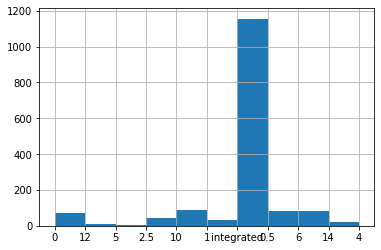

In [238]:
# Sampling deapth distribution:
df_alg["sampling depth"].hist()

In [239]:
# rescale values of samples from "integrated phytoplankton net"
# df_alg.loc[:,"PSP":"Dinophysis tripos"]=df_alg.loc[df_alg["sampling method"] == "phytoplankton net"].loc[:,"PSP":"Dinophysis tripos"]/100
# df_alg.loc[df_alg["sampling method"] == "phytoplankton net"]

In [240]:
# Count of missing values
df_alg.isnull().sum()

date                       0
sampling station           0
sampling depth             0
sampling method            0
PSP                        6
DSP                        1
DSP_like                  64
ASP                      542
Dinophysis caudata         1
Dinophysis fortii          1
Phalacroma rotundatum      1
Dinophysis sacculus        1
Dinophysis tripos          1
dtype: int64

## Toxins dataset

In [241]:
# Create toxins dataframe
# empty cells [test not available, not in the program of testing] -> NaN
df_tox = pd.read_csv("data/Toxins_Podatki_1994_onwards_24062021_Martin_1_0.csv", na_values=["x", "? (no data)", "unreliable", 
            "niso več delali analiz, ker nimajo školjk konzumne velikosti"], sep=";")  
df_tox = df_tox.drop(columns=["data source", "PSP toxins", "ASP toxins", "yessotoxins"])

# create timestamp
# It produces a mistake 08/11/2019 -> 2019-08-11 !!!! What to do?
df_tox["date"] = pd.to_datetime(df_tox["date"])

# sort by date attribute
df_tox = df_tox.sort_values('date')

# set DateTime as index
df_tox.set_index('date', inplace=True)

df_tox

,sampling station,lipophylic toxins,lipophylic toxins (OA (µg/kg)),lipophylic toxins (DTX2 (µg/kg)),ban start,ban stop
date,,,,,,
1989-09-15,35,poz,NaN,NaN,NaN,NaN
1989-09-15,24,poz,NaN,NaN,NaN,NaN
1989-09-25,35,NaN,NaN,NaN,y,NaN
1989-09-25,24,NaN,NaN,NaN,y,NaN
1989-09-25,0DB2,poz,NaN,NaN,y,NaN
...,...,...,...,...,...,...
2019-12-20,35,< MD,< MD,< MD,NaN,NaN
2019-12-20,0DB2,< MD,< MD,< MD,NaN,NaN
2019-12-30,24,< MD,< MD,< MD,NaN,NaN


In [242]:
# Adjustments to the dataset values
# ["< MD", "< 3 mg DA/kg", "< 0,2 mg DA/kg", "0,2 mg DA/kg (neg)", "0.29 mg/kg", "neg (na meji)"] -> neg
df_tox.replace(to_replace=["< MD", "< 3 mg DA/kg", "< 0,2 mg DA/kg", "0,2 mg DA/kg (neg)", "0.29 mg/kg", "neg (na meji)"], value="neg", inplace=True)
# ">320, ocena 920" -> 920 [estimated value], 
df_tox.replace(">320, ocena 920", 920, inplace=True)
#>320, ocena 1580" -> 1580
df_tox.replace(">320, ocena 1580", 1580, inplace=True)
#">320, ocena 1880" -> 1880
df_tox.replace(">320, ocena 1880", 1880, inplace=True)
#">320, ocena 336" -> 336
df_tox.replace(">320, ocena 336", 336, inplace=True)
# ">320, ocena 470" -> 470, 
df_tox.replace(">320, ocena 470", 470, inplace=True)
#">240, ocena 510" -> 510, 
df_tox.replace(">240, ocena 510", 510, inplace=True)

# at index 947: yessotoxins="0.29 mg/kg" [need to conver to poz / neg); Or should we ignore yesstoxinsv since only one 4 values?

In [243]:
# Standardise station names
df_tox["sampling station"].replace("0035", 35, inplace=True)
df_tox["sampling station"].replace("0024", 24, inplace=True)

# Change station names to str
df_tox["sampling station"] = df_tox["sampling station"].astype(str)

In [244]:
# Mapping num values -> "poz" or "neg" based on treshold (173 µg/kg = legal limit concentration for DSP toxins, that induce shellfish harvesting ban)
numbers = [str(x) for x in range(10)]
for idx, value in df_tox["lipophylic toxins (OA (µg/kg))"].iteritems():
    if any(x in str(value) for x in numbers):
        if int(value) >= 173:
            #print(f"old value: {value}")
            value = "poz"
            #print(f"new value: {value}")
            df_tox["lipophylic toxins (OA (µg/kg))"][idx] = value
        else:
            #print(f"old value: {value}")
            value = "neg"
            #print(f"new value: {value}")
            df_tox["lipophylic toxins (OA (µg/kg))"][idx] = value

In [245]:
# Joining lipophylic toxins into one column.
# Just copying values from "lipophylic toxins (OA (µg/kg))"[930:] to "lipophylic toxins" and keep the latter as "lipophylic toxins (DTX2 (µg/kg))" has no positive values.
df_tox["lipophylic toxins"][930:] = df_tox["lipophylic toxins (OA (µg/kg))"][930:]

# Remove columns "lipophylic toxins (OA (µg/kg))" and "lipophylic toxins (DTX2 (µg/kg))" from dataframe
df_tox.drop(columns=["lipophylic toxins (OA (µg/kg))", "lipophylic toxins (DTX2 (µg/kg))"], inplace=True)
print(f"lipophylic toxins classes:") 
df_tox["lipophylic toxins"].value_counts()

lipophylic toxins classes:


neg    1066
poz     148
Name: lipophylic toxins, dtype: int64

In [246]:
# #Old code: Loop to map to neg/poz, discuss with Vid!
# df_tox_OA_cat = df_tox["lipophylic toxins (OA (µg/kg))"].applymap(
#     lambda x: "poz" if type(x) == int or type(x) == float and x >= 173 else("neg" if type(x) == int or type(x) == float and x < 173)
# )
# df_tox_OA_cat

In [247]:
df_tox

,sampling station,lipophylic toxins,ban start,ban stop
date,,,,
1989-09-15,35,poz,NaN,NaN
1989-09-15,24,poz,NaN,NaN
1989-09-25,35,NaN,y,NaN
1989-09-25,24,NaN,y,NaN
1989-09-25,0DB2,poz,y,NaN
...,...,...,...,...
2019-12-20,35,neg,NaN,NaN
2019-12-20,0DB2,neg,NaN,NaN
2019-12-30,24,neg,NaN,NaN


In [248]:
df_tox.describe()

,sampling station,lipophylic toxins,ban start,ban stop
count,1373,1214,83,83
unique,3,2,1,1
top,24,neg,y,y
freq,515,1066,83,83


In [249]:
# Show Missing values
df_tox.isnull().sum()

sampling station        0
lipophylic toxins     159
ban start            1290
ban stop             1290
dtype: int64

# Consolidating datasets 

Divide algae dataset by locations 35, 24 and 0DB2.

In [250]:
# df_alg for station 35
df_alg_35 = df_alg[df_alg["sampling station"] == "35"].copy()
# df for station 24
df_alg_24 = df_alg[df_alg["sampling station"] == "24"].copy()
# df for station 0DB2
df_alg_0DB2 = df_alg[df_alg["sampling station"] == "0DB2"].copy()

Divide toxin dataset by locations 35, 24 and 0DB2.

In [251]:
# df_tox for station 35
df_tox_35 = df_tox[df_tox["sampling station"] == "35"].copy()
# df_tox for station 24
df_tox_24 = df_tox[df_tox["sampling station"] == "24"].copy()
# df_tox for station 0DB2
df_tox_0DB2 = df_tox[df_tox["sampling station"] == "0DB2"].copy()

Prepare df for consolidated datasets by locations 35, 24 and 0DB2.

In [252]:
# df_cons for station 35
df_cons_35 = df_alg_35.copy()
df_cons_35["lipophylic_toxins"] = np.nan

# df_cons for station 24
df_cons_24 = df_alg_24.copy()
df_cons_24["lipophylic_toxins"] = np.nan

# df_cons for station 0DB2 
df_cons_0DB2 = df_alg_0DB2.copy()
df_cons_0DB2["lipophylic_toxins"] = np.nan

In [253]:
df_tox_35

,sampling station,lipophylic toxins,ban start,ban stop
date,,,,
1989-09-15,35,poz,NaN,NaN
1989-09-25,35,NaN,y,NaN
1989-12-10,35,NaN,NaN,y
1990-07-25,35,poz,y,NaN
1990-08-02,35,neg,NaN,y
...,...,...,...,...
2019-10-25,35,neg,NaN,NaN
2019-11-08,35,neg,NaN,NaN
2019-11-26,35,neg,NaN,NaN


#### Location 35

In [261]:
# Loop to add appropriate toxin test results to algae sample; add first toxin test after timestamp of an algae sample but no older tests then 30 days.
max_range = pd.Timedelta(30, unit="day")
min_range = pd.Timedelta(0, unit="day")
matches_35 = 0

# Iterate over consolidated df and select a date of the algae sample
for id_alg, date_alg in df_cons_35["date"].iteritems():
    # Iterate over toxin df and select the date of test 
    for date_tox in df_tox_35.index:
        # Calculate the timespan between algae sample and toxin test 
        timespan = date_tox - date_alg
        # If timespan within 30 days
        if min_range <= timespan <= max_range:
            # The toxin result on first acceptable toxin test day (date_tox) 
            tox_result = df_tox_35.loc[date_tox, "lipophylic toxins"]
            # Use only non-NaN tox_result (neg/pos)
            if type(tox_result) == str:
                df_cons_35["lipophylic_toxins"][id_alg] = tox_result
                matches_35 += 1
                break # problem: a tox_result should be use multiple times untill it fits the time_frame (I think they do!)
                # problem je določat katero vrednost vzame kadar je več možnih (sedaj vzame najbližjo datumu)
print(f"Found matching test dates for location 35: {matches_35}")

Found matching test dates for location 35: 452


In [262]:
pd.set_option("max_rows", 15)
df_cons_35

,date,sampling station,sampling depth,sampling method,PSP,DSP,DSP_like,ASP,Dinophysis caudata,Dinophysis fortii,Phalacroma rotundatum,Dinophysis sacculus,Dinophysis tripos,lipophylic_toxins
0,1994-05-17,35,0,Niskin,1206.0,68.0,NaN,NaN,27.0,0.0,21.0,0.0,0.0,NaN
1,1994-05-17,35,12,Niskin,31.0,16.0,NaN,NaN,13.0,0.0,3.0,0.0,0.0,NaN
2,1994-05-17,35,5,Niskin,0.0,41.0,NaN,NaN,38.0,0.0,3.0,0.0,0.0,NaN
8,1994-06-21,35,0,bucket,0.0,20.0,NaN,NaN,8.0,0.0,0.0,0.0,0.0,NaN
11,1994-07-14,35,0,bucket,54.0,26.0,NaN,NaN,2.0,2.0,20.0,2.0,0.0,poz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,2020-10-28,35,integrated,hose sampler,10.0,150.0,0.0,287200.0,0.0,150.0,0.0,0.0,0.0,NaN
1572,2020-11-06,35,integrated,hose sampler,20.0,20.0,0.0,27200.0,0.0,10.0,10.0,0.0,0.0,NaN
1575,2020-11-18,35,integrated,hose sampler,0.0,30.0,0.0,74600.0,0.0,10.0,20.0,0.0,0.0,NaN
1578,2020-11-27,35,integrated,hose sampler,0.0,0.0,0.0,10800.0,0.0,0.0,0.0,0.0,0.0,NaN


#### Location 24

In [264]:
# Loop to add appropriate toxin test results to algae sample; add first toxin test after timestamp of an algae sample but no older tests then 30 days.
max_range = pd.Timedelta(30, unit="day")
min_range = pd.Timedelta(0, unit="day")
matches_24 = 0

# Iterate over consolidated df and select a date of the algae sample
for id_alg, date_alg in df_cons_24["date"].iteritems():
    # Iterate over toxin df and select the date of test 
    for date_tox in df_tox_24.index:
        # Calculate the timespan between algae sample and toxin test 
        timespan = date_tox - date_alg
        # If timespan within 30 days
        if min_range <= timespan <= max_range:
            # The toxin result on first acceptable toxin test day (date_tox) 
            tox_result = df_tox_24.loc[date_tox, "lipophylic toxins"]
            # Use only non-NaN tox_result (neg/pos)
            if type(tox_result) == str:
                df_cons_24["lipophylic_toxins"][id_alg] = tox_result
                matches_24 += 1
                break # problem: a tox_result should be use multiple times untill it fits the time_frame (I think they do!)
                # problem je določat katero vrednost vzame kadar je več možnih (sedaj vzame najbližjo datumu)
print(f"Found matching test dates for location 24: {matches_24}")

Found matching test dates for location 24: 456


#### Location 0DB2

In [265]:
# Loop to add appropriate toxin test results to algae sample; add first toxin test after timestamp of an algae sample but no older tests then 30 days.
max_range = pd.Timedelta(30, unit="day")
min_range = pd.Timedelta(0, unit="day")
matches_0DB2 = 0

# Iterate over consolidated df and select a date of the algae sample
for id_alg, date_alg in df_cons_0DB2["date"].iteritems():
    # Iterate over toxin df and select the date of test 
    for date_tox in df_tox_0DB2.index:
        # Calculate the timespan between algae sample and toxin test 
        timespan = date_tox - date_alg
        # If timespan within 30 days
        if min_range <= timespan <= max_range:
            # The toxin result on first acceptable toxin test day (date_tox) 
            tox_result = df_tox_0DB2.loc[date_tox, "lipophylic toxins"]
            # Use only non-NaN tox_result (neg/pos)
            if type(tox_result) == str:
                df_cons_0DB2["lipophylic_toxins"][id_alg] = tox_result
                matches_0DB2 += 1
                break # problem: a tox_result should be used multiple times as long as it fits the time_frame (I think they do!) ampak
                # problem je določat katero vrednost vzame kadar je več možnih (sedaj vzame najbližjo datumu).
print(f"Found matching test dates for location 0DB2: {matches_0DB2}")

/var/folders/4p/mr19cxrs6_z3dsfws0cjcwfw0000gn/T/ipykernel_1186/1738842655.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cons_0DB2["lipophylic_toxins"][id_alg] = tox_result
/Users/mmarzi/.pyenv/versions/3.8.0/envs/graphs/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Found matching test dates for location 0DB2: 287


#### Consolidate datasets

In [270]:
# All consolidated df per of each location
df_cons_loc = [df_cons_35, df_cons_24, df_cons_0DB2]
# Concatenated dataframe from each location 
df_cons = pd.concat(df_cons_loc)

# sort by date attribute
df_cons = df_cons.sort_values('date')

pd.set_option("max_rows", 15)
df_cons

,date,sampling station,sampling depth,sampling method,PSP,DSP,DSP_like,ASP,Dinophysis caudata,Dinophysis fortii,Phalacroma rotundatum,Dinophysis sacculus,Dinophysis tripos,lipophylic_toxins
0,1994-05-17,35,0,Niskin,1206.0,68.0,NaN,NaN,27.0,0.0,21.0,0.0,0.0,NaN
5,1994-05-17,24,5,Niskin,126.0,8.0,NaN,NaN,0.0,0.0,8.0,0.0,0.0,NaN
4,1994-05-17,24,12,Niskin,222.0,2.0,NaN,NaN,0.0,0.0,2.0,0.0,0.0,NaN
3,1994-05-17,24,0,Niskin,4188.0,17.0,NaN,NaN,8.0,0.0,0.0,0.0,0.0,NaN
2,1994-05-17,35,5,Niskin,0.0,41.0,NaN,NaN,38.0,0.0,3.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,2020-11-27,24,integrated,hose sampler,10.0,10.0,0.0,13000.0,0.0,0.0,0.0,0.0,0.0,NaN
1578,2020-11-27,35,integrated,hose sampler,0.0,0.0,0.0,10800.0,0.0,0.0,0.0,0.0,0.0,NaN
1581,2020-12-15,35,integrated,hose sampler,0.0,20.0,0.0,1800.0,0.0,0.0,0.0,0.0,0.0,NaN
1580,2020-12-15,24,integrated,hose sampler,10.0,20.0,0.0,1200.0,0.0,0.0,10.0,0.0,0.0,NaN
